In [2]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")
#sys.path.insert(0, r'/home/pirwin/Git/HelperPI')
import itertools
import HelperPI
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.formula.api as sts
import numpy as np
import math
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from scipy import interp
from sklearn.metrics import r2_score

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (11,8)

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [14]:
#base, dtypesdf = helper.readData(sql)
base = pd.read_csv(r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\tab_model.csv', parse_dates=['DATE_VALUE'])
base = base[base['TARGET_VALUE15'] > 0]
#base = pd.read_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/tab_model.csv',parse_dates=['DATE_VALUE'])
base['DAYS_BTW_PURCH'] = base['DAYS_AS_CUSTOMER']/base['TOTAL_TRANSACTIONS']
#dtypes = helper.getDtypes(base)
base.describe()

,MEDHINC_CY,MEDAGE_CY,CLOSEST_BP,CLOSEST_CAB,MALES_IN_HOUSHOLD,FEMALES_IN_HOUSHOLD,REWARDS_CUSTOMER,DAYS_AS_CUSTOMER,TOTAL_TRANSACTIONS,REW_TRANSACTIONS,TOTAL_SPEND,DAYS_SINCE_PURCHASE,TARGET_VALUE15,TARGET_PURCH_NEXT15,DAYS_BTW_PURCH
count,1648.000000,1648.000000,1723.000000,1672.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.0,1723.000000
mean,59651.429612,39.745752,27.386332,112.392883,0.918746,0.361579,0.819501,2514.650029,46.430644,37.951828,3583.745735,310.585607,121.592577,1.0,185.195210
std,22158.290463,5.646996,31.554356,126.321089,0.621257,0.538709,0.384714,1269.508919,98.138541,91.571260,5586.055731,559.723926,181.720307,0.0,296.771508
min,0.000000,0.000000,0.070000,1.590000,0.000000,0.000000,0.000000,66.000000,1.000000,0.000000,2.990000,8.000000,0.050000,1.0,1.686525
25%,42682.750000,36.000000,8.160000,28.700000,1.000000,0.000000,1.000000,1381.500000,8.000000,2.000000,603.110000,38.000000,31.955000,1.0,47.443548
50%,55536.000000,39.500000,16.100000,64.360000,1.000000,0.000000,1.000000,2853.000000,21.000000,13.000000,1818.170000,101.000000,66.980000,1.0,93.666667
75%,71318.750000,43.000000,35.750000,140.002500,1.000000,1.000000,1.000000,3721.500000,49.000000,41.000000,4320.363500,294.500000,137.948500,1.0,198.166667
max,200001.000000,68.000000,376.660000,613.680000,4.000000,4.000000,1.000000,3929.000000,2115.000000,2048.000000,75526.550000,3537.000000,3689.950000,1.0,3537.000000


In [15]:
collist = ['MEDHINC_CY','MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE',
          'DAYS_BTW_PURCH']
X = base[collist]
y = base['TARGET_VALUE15']

In [16]:
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / X.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.01]

,column_name,missing_count,missing_ratio
0,MEDHINC_CY,75,0.043529
1,MEDAGE_CY,75,0.043529


MEDHINC_CY Coef: 0.01  pval:  0.6196
MEDAGE_CY Coef: 0.04  pval:  0.1300
CLOSEST_BP Coef: 0.06  pval:  0.0165
MALES_IN_HOUSHOLD Coef: 0.01  pval:  0.5709
FEMALES_IN_HOUSHOLD Coef: 0.00  pval:  0.8994
REWARDS_CUSTOMER Coef: 0.08  pval:  0.0007
DAYS_AS_CUSTOMER Coef: 0.00  pval:  0.8807
REW_TRANSACTIONS Coef: -0.01  pval:  0.6138
TOTAL_SPEND Coef: 0.12  pval:  0.0000
DAYS_SINCE_PURCHASE Coef: -0.03  pval:  0.2766
DAYS_BTW_PURCH Coef: -0.06  pval:  0.0133


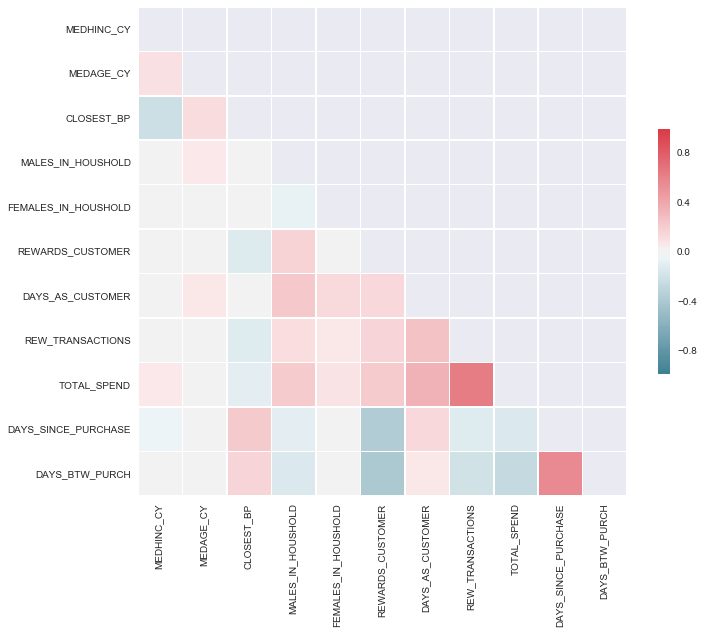

In [18]:
imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr = imr.fit(X)
imputed_data = pd.DataFrame(imr.transform(X.values), columns = collist)

for var in collist:
    coef, pval = stats.pointbiserialr(imputed_data[var].as_matrix(), y.as_matrix())
    
    print(var + ' Coef: %.2f  pval:  %.4f' % (coef, pval))


collist2 = ['MEDHINC_CY','MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE',
          'DAYS_BTW_PURCH']

imputed_data2 = imputed_data[collist2]
    
corr = imputed_data2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})